In [1]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline
import seaborn as sns
import torch
import pandas as pd
import torchvision
from tqdm.notebook import tqdm
from torchvision.io import read_image
from torch.utils.data import Dataset, random_split
from torchvision.transforms import Normalize
import torchsummary
from torch.optim import lr_scheduler
from pytorch_lightning.callbacks import Callback
import torch.nn as nn
from tempfile import TemporaryDirectory
import time
%matplotlib inline
matplotlib_inline.backend_inline.set_matplotlib_formats("svg", "pdf")  # For export
sns.reset_orig()
sns.set()


# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
# Tensorboard extension (for visualization purposes later)
%load_ext tensorboard
# Setting the seed

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print("Device:", device)

Device: cuda:0


## Notes: 
- `reg-ing prev cell`: Do i have to calculate mean and std everytime I add new shot do database?
-  `reg-ing next cell`: I belive images should be normalized with mean=0 and std=1, but they look very strange after denormalization. Mb mean and std where calculated out of small amount of data (2 shots)?
- `general`: Implement TensorBoard!
- `normalization`: There're some artefacts of normalization appearing after `imshow()`.
- `ad normalization`: There's BatchNorm2d in first layer of model. Do I actually need to normalize?
- `ad training data`: Currently i use images only from RIS1. Also there are too many completely black images, and far less images with H-mode and L-mode. I can treat H-mode and L-mode as outlayers and look for them as for anomalies, or create a dataset wich would contain more or less the same amount of H and L modes.

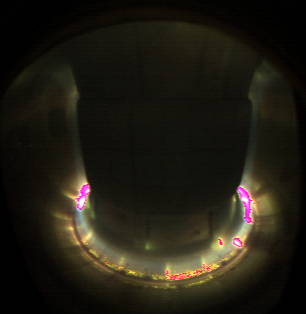 

## Create a training dataset

In [11]:
shots = [16534, 16769, 16773, 18057, 18130, 19237, 19240, 19379]
shot_df = pd.DataFrame([])
for shot in shots:
    df = pd.read_csv(f'/compass/Shared/Users/bogdanov/vyzkumny_ukol/LHmode-detection-shot{shot}.csv')
    shot_df = pd.concat([shot_df, df], axis=0)

df_mode = shot_df['mode'].copy()
df_mode[shot_df['mode']=='L-mode'] = 0
df_mode[shot_df['mode']=='H-mode'] = 1
df_mode[shot_df['mode']=='ELM'] = 2
shot_df['mode'] = df_mode
shot_df = shot_df.reset_index(drop=True) #each shot has its own indexing starting from 0 to 2232

# Images from RIS2 camera
ris2_names = shot_df['filename'].str.replace('RIS1', 'RIS2')
shot_df_RIS2 = shot_df.copy()
shot_df_RIS2['filename'] = ris2_names

# Combine both datasets
shot_df = pd.concat([shot_df, shot_df_RIS2], axis=0)
shot_df = shot_df.reset_index(drop=True) #each shot has its own indexing starting from 0 to 2232

# Precalculated mean and std for each color and each image 
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])

Vast majority of original dataset are L-modes. Here I'm balancing the data so that `len(l_modes)==len(hmodes_and_elms)`

In [12]:
hmodes_and_elms = shot_df[shot_df['mode']!=0]
l_modes = shot_df[shot_df['mode']==0].sample(len(hmodes_and_elms))
shot_df = pd.concat([hmodes_and_elms, l_modes], axis=0)
shot_df = shot_df.reset_index(drop=True)

In [22]:
class ImageDataset(Dataset):
    def __init__(self, annotations, img_dir, mean, std):
        self.img_labels = annotations #pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.mean = mean
        self.std = std

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.loc[idx, 'filename'])
        image = read_image(img_path).double()
        normalized_image = (image - self.mean[:, None, None])/(255*self.std[:, None, None])
        label = self.img_labels.iloc[idx, 1]
        return normalized_image, label 
        

# Create PyTorch Dataset from RIS imgs
dataset = ImageDataset(annotations=shot_df[['filename', 'mode']], img_dir='/compass/Shared/Users/bogdanov/vyzkumny_ukol',\
                        mean=mean, std=std)


### TODO: adjust dataset sizes

In [65]:
from torch.utils.data import DataLoader

batch_size = 64

train_set, test_set, val_set = random_split(dataset, [.6, .2, .2])

train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=False)

In [66]:
dataloaders = {'train':train_dataloader, 'val':val_dataloader} #TODO: add test loader in train function and consequenlty to this dict
dataset_sizes = {x: len(dataloaders[x].dataset) for x in ['train', 'val']}

Chyba v obrazcich - jsou tam NaN hodnoty!

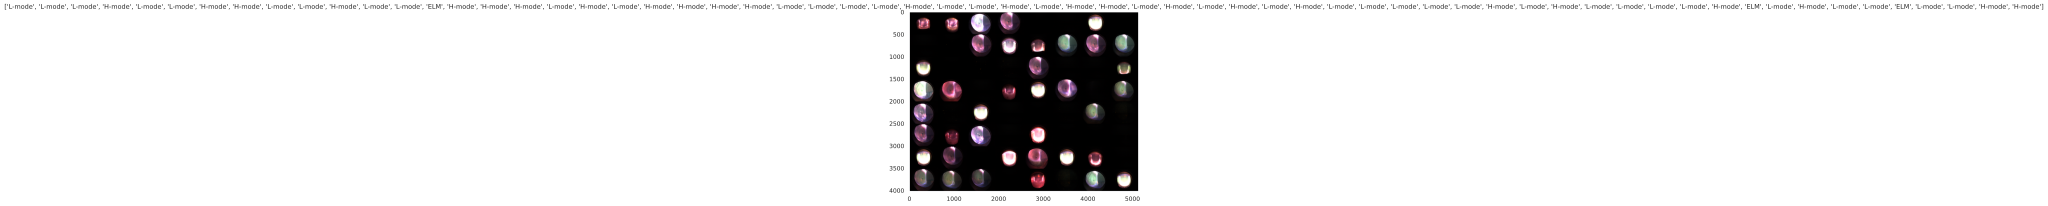

In [67]:
def imshow(inp, mean, std, title=None):
    """Display image for Tensor."""
    inp = inp.cpu().numpy().transpose((1, 2, 0))
    #inp = inp/255
    inp = np.clip(inp, 0, 1)
    fig, ax = plt.subplots(figsize=(10,6))
    ax.imshow(inp)
    ax.grid(False)
    if title is not None:
        plt.title(title)


modes = ['L-mode', 'H-mode', 'ELM']
# Get first nine images from batch of training data
batch = next(iter(dataloaders['train']))[:][:4]
inputs, classes = batch
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, mean=mean, std=std, title=[modes[x] for x in classes])

$/\backslash\\$
 | | **Labels seem to not correspond to images**

### Searching through dataloader for all 3 modes
Yeah it's a dummy way to test images, but i wanted to test loader, and I kinda enjoyed implementing this

In [68]:
def search_for_LHELM(dataloader):
    for modeind in [0,1,2]:
        lhmodes_and_Elms = next(iter(dataloader))[0][0]
        lhmodes_and_Elms_names = next(iter(dataloader))[1][0]
        
        while modeind not in lhmodes_and_Elms_names:
            inputs, classes = next(iter(dataloader))
            if modeind in classes:
                lhmodes_and_Elms = torch.cat((lhmodes_and_Elms, inputs[np.where(classes==modeind)[0]][0]))
                lhmodes_and_Elms_names = torch.cat((lhmodes_and_Elms_names.view(modeind), torch.tensor([modeind])))
                print(f'{modes[modeind]} was appended to the example')
    return lhmodes_and_Elms, lhmodes_and_Elms_names

#L_H_andelm, L_H_andelm_name = search_for_LHELM(train_dataloader)
# example_out = torchvision.utils.make_grid(L_H_andelm.permute(2,0,1)/255)
#imshow(example_out, mean=mean, std=std, title=[modes[x] for x in classes])

## Playing with TensorBoard

In [69]:
from datetime import datetime
import time 
timestamp = datetime.fromtimestamp(time.time()).strftime("%d-%m-%Y, %H-%M-%S")#9 times!

In [70]:
from datetime import datetime
import time 
timestamp = datetime.fromtimestamp(time.time()).strftime("%d-%m-%Y, %H-%M-%S")#9 times!
# create grid of images
# default `log_dir` is "runs" - we'll be more specific here
writer = SummaryWriter(f'runs/TB_ris1_{timestamp}')

# write to tensorboard
writer.add_image(f'run {timestamp} four_compass images', out)
writer.close()

## Import pretrained model


In [71]:
pretrained_model = torchvision.models.resnet18(weights='IMAGENET1K_V1')

num_ftrs = pretrained_model.fc.in_features
# Here the size of each output sample is set to 3.
# Alternatively, it can be generalized to ``nn.Linear(num_ftrs, len(modes))``.
pretrained_model.fc = torch.nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM


### I will try to freeze all layers except 4-th and fc layer

In [72]:
# for name, para in pretrained_model.named_parameters():
#     if "layer4" in name or "fc" in name:
#         continue
#     else:
#         para.requires_grad = False

### Alternatively freeze all the weights excepts those of last fc layer

In [73]:
for param in pretrained_model.parameters():
    param.requires_grad = False
 
# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Linear(num_ftrs, 3) #3 classes: L-mode, H-mode, ELM

In [74]:
pretrained_model = pretrained_model.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer = torch.optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Here I simply print the structure of model for input with size (3,500,640)

In [75]:
writer.add_graph(pretrained_model, inputs.float().to(device))
writer.close()

In [76]:
#torchsummary.summary(pretrained_model, (3,500,640))

In [77]:
# for name, para in pretrained_model.named_parameters():
#     print("="*40)
#     print(f"name: {name}")
#     print(para)

## Tracking model training with TensorBoard

In [78]:
# helper functions
def matshow(img, std, mean, one_channel=False):
    if one_channel:
        img = img.mean.cpu()(dim=0)
    img = img.cpu()*std[:,None, None] + mean[:,None, None]    # unnormalize
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))

def images_to_probs(net, images):
    '''
    Generates predictions and corresponding probabilities from a trained
    network and a list of images
    '''
    output = net(images)
    # convert output probabilities to predicted class
    _, preds_tensor = torch.max(output, 1)
    preds = np.squeeze(preds_tensor.cpu().numpy())
    return preds, [torch.nn.functional.softmax(el, dim=0)[i].item() for i, el in zip(preds, output)]


def plot_classes_preds(net, images, labels):
    '''
    Generates matplotlib Figure using a trained network, along with images
    and labels from a batch, that shows the network's top prediction along
    with its probability, alongside the actual label, coloring this
    information based on whether the prediction was correct or not.
    Uses the "images_to_probs" function.
    '''
    preds, probs = images_to_probs(net, images)
    # plot the images in the batch, along with predicted and true labels
    fig = plt.figure(figsize=(7,4))
    for idx in np.arange(4):
        ax = fig.add_subplot(1, 4, idx+1, xticks=[], yticks=[])
        matshow(images[idx], mean, std)
        #imshow(images[idx], mean, std,)
        ax.set_title("{0}, {1:.1f}%\n(label: {2})".format(
            classes[preds[idx]],
            probs[idx] * 100.0,
            classes[labels[idx]]),
                    color=("green" if preds[idx]==labels[idx].item() else "red"))
    return fig

## Training
### Original training function was copied from [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html#finetuning-the-convnet) and modified in order to integrate tensorboard

In [79]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')
    
        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                i=0 #TODO: eliminate the need in that dummy iterative for tensorboard part
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device).float() #TODO: is it smart to convert double to float here?
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs) #2D tensor with shape Batchsize*len(modes)
                        #TODO: inputs.type. 
                        _, preds = torch.max(outputs, 1) #preds = 1D array of indicies of maximum values in row. ([2,1,2,1,2]) - third feature is largest in first sample, second in second...
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0) #!!! Why is it multiplied by batchsize???
                    running_corrects += torch.sum(preds == labels.data) #How many correct answers

                    i+=1
                    if i % 10==9:    # every 1000 mini-batches...
                        # ...log the running loss
                        writer.add_scalar(f'{phase}ing loss',
                                        running_loss / 10,
                                        epoch * len(dataloaders[phase]) + i)
                        
                    #tensorboard part
                    if i % 32 == 31:    # every 1000 mini-batches...
                        # ...log a Matplotlib Figure showing the model's predictions on a
                        # random mini-batch
                        writer.add_figure('predictions vs. actuals',
                                        plot_classes_preds(model, inputs, labels),
                                        global_step=epoch * len(dataloaders[phase]) + i)
                        writer.close()
                        running_loss = 0.0
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    writer.add_scalar(f'best_accuracy for epoch',
                                        epoch_acc,
                                        epoch)
                    writer.close()
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

### Problem with endless output
`imshow()` is not suitable for purpose in line 60 of previous cell

In [81]:
model = train_model(pretrained_model, criterion, optimizer,
                         exp_lr_scheduler, num_epochs=2)

Epoch 0/2
----------
train Loss: 0.9365 Acc: 0.4534
val Loss: 0.8539 Acc: 0.5507

Epoch 1/2
----------
train Loss: 0.8328 Acc: 0.6254
val Loss: 0.8121 Acc: 0.5894

Training complete in 1m 7s
Best val Acc: 0.589372


In [82]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_laoder using model, and return both images and encodings
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding images", leave=False):
        with torch.no_grad():
            z = model(imgs.to(device).float())
        img_list.append(imgs)
        embed_list.append(z)
    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))


train_img_embeds = embed_imgs(model, train_dataloader)
test_img_embeds = embed_imgs(model, test_dataloader)

Encoding images:   0%|          | 0/20 [00:00<?, ?it/s]

Encoding images:   0%|          | 0/7 [00:00<?, ?it/s]

In [ ]:
NUM_IMGS = len(test_set)

writer.add_embedding(
    test_img_embeds[1][:NUM_IMGS],  # Encodings per image
    metadata=[test_set[i][1] for i in range(NUM_IMGS)],  # Adding the labels per image to the plot
    label_img=(test_img_embeds[0][:NUM_IMGS] + 1) / 2.0,
)  # Adding the original images to the plot

In [ ]:
# def select_n_random(dataloader, nbatches=1):
#     '''
#     Selects n random datapoints and their corresponding labels from a dataset
#     '''
#     images, labels = next(iter(dataloader))
#     for i, batch in enumerate(dataloader):
#         image, label = batch
#         images = torch.cat((images, image))
#         labels = torch.cat((labels, label))
#         if i==nbatches:
#             break
#     return images, labels

# images, labels = select_n_random(test_dataloader)


In [ ]:
#  # log embeddings

# features = images.view(-1, 3*500*640)
# writer.add_embedding(features,
#                     metadata=[modes[x] for x in labels],
#                     label_img=images)
# writer.close()